<a href="https://colab.research.google.com/github/SERVIR-Amazonia/MANGLEE/blob/main/Manglee_M2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

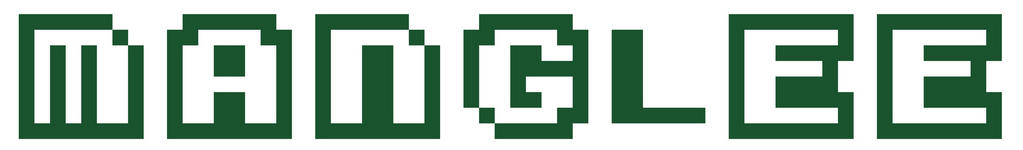

## **Módulo 2: Algoritmo de clasificación**

---

Requisitos
* Cuenta de Google Earth Engine (GEE) y Google Colab
* Archivo vectorial de polígono AOI.shp cargado a su cuenta GEE como un Asset
* Archivo vectorial de puntos training.shp. En la tabla de atributos deberá tener una columna con el nombre 'Class'
* Archivo vectorial de puntos validation.shp. En la tabla de atributos deberá tener una columna con el nombre 'Clase'
* Dirección en GEE del compuesto temporal óptico generado con el módulo 1
---
Este código ha sido adaptado por Lorena Caiza (ECOCIENCIA/SERVIR-Amazonia/CAMBIUM UVa SORIA)
Ultima modificación 15/05/2023

Los documentos, difusión y resultados los puedes encontrar en: https://sites.google.com/view/mangleetrain/inicio

Licensed under a Creative Commons Attribution 4.0 license. (CC-BY). 

##Cargar librerías y autenticar la cuenta de GEE

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, gamma, f, chi2
import IPython.display as disp
%matplotlib inline
!pip install geemap
import folium
import ee
import geemap
import ee.mapclient
from IPython.display import display


Activar la cuenta de Google Earth Engine

In [ ]:
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=xPT2vzbUZfrgokRVhwqIMvm3q1nnQWTtz-A0AJrlMf4&tc=78hG2RorEA1gEQkdEIrZtH4p6jJ3LfAtb0pBgMoD6lw&cc=6uA1B1jPcJkoTTFdX5NxyMR3j1tgYlOT2YEsndbK29Y

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AbUR2VPbSn5VOUc6zIs4fi-RjmbrZ9smUyIGyB_enZPhknzBVbQpvoDbfYE

Successfully saved authorization token.


Ingresar el área de estudio, los puntos de entrenamiento, validación y el compuesto Sentinel 2. 
Poner la ubicación de los archivos, disponible en la carpeta Assets de su cuenta de usuario de GEE

In [ ]:
AOI= ee.FeatureCollection('users/lorenacaizamorales/SERVIR/AOI_SV')
##Training
train=ee.FeatureCollection('projects/ee-lorenacaizamorales/assets/TRAINING_mayo'); 
##validation
validationPts = ee.FeatureCollection('users/lorenacaizamorales/SERVIR/Validacion_2022')
## Ingrese la direccion del Compuesto temporal libre de nubes  
S2_C= ee.Image('projects/ee-lorenacaizamorales/assets/CT_BOA_2022')


##Compuesto temporal SAR apartor de datos Sentinel 1 

Definir las fechas del primer periodo para los datos Sentinel 1 

In [ ]:
S1start_date=ee.Date('2022-08-01')
S1end_date=ee.Date('2022-12-31')

In [ ]:
#Parámetros de visualización 
vis = {"bands": ['B8', 'B11', 'B4'], "min": 0.05, "max": 6000, "gamma": 1.5}        
bands=['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12']
#//------------------------------Mascaras--------------------------------------------------//
##m.add_ee_layer(DTMMask)
NDVIMask  = S2_C.select('NDVI').gt(0.25)
S2_C_Mask = S2_C##.updateMask(NDVIMask).updateMask(DTMMask)

In [ ]:
##///----------------------------------SAR Sentinel 1 -----------------------///
##//calcula los índices SAR
#RFDI
#RVI
##VV/VH
def rfdi_fun(img):
   pwr = ee.Image(10).pow(img.divide(10)).set('system:time_start', img.get('system:time_start'));## // first convert to linear units (power)
   rfdi= pwr.select('VV').subtract(pwr.select('VH')).divide(pwr.select('VV').add(pwr.select('VH'))).rename('RFDI');
   VV_VH = img.select('VV').divide(img.select('VH')).rename('VV_VH');
   rvi = pwr.expression('4*VH/(VV+VH)',{'VH':pwr.select('VH'),'VV':pwr.select('VV')}).rename('RVI');
   return img.addBands(rfdi).addBands(VV_VH).addBands(rvi)

In [ ]:
# Importa y filtra la collección S1.
##// Carga la colección  Sentinel-1 C-band SAR Ground Range collection (log scale, VV, descending) 
s1_All = (
    ee.ImageCollection('COPERNICUS/S1_GRD')
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))# mostly is used in VV, I tried with VH but I had less bands
    .filter(ee.Filter.eq('instrumentMode', 'IW'))# default mode
    .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))# try for ascending or descending, but for Texas worked better DESCENDING
    .filterDate(S1start_date, S1end_date)
    .filterBounds(AOI)
    )
s1_All

In [ ]:
#Crea un compuesto y aplica un filtro para reducir el ruido
S1All = (s1_All).map(rfdi_fun).median()
S1_C = ee.Image.cat([S1All.select(['VV','VH','VV_VH','RVI','RFDI'])]).clip(AOI).focalMean(30, 'square','meters'); 
S1_C

In [ ]:
# Define los parámetros de visualización y muestra la imagen SAR
Map = geemap.Map(center=(-2.6, -80.0), zoom=10)
classVis = {'min': -25, 'max': -5} ;
Map.addLayer(S1_C,classVis,'Compuesto S1');
Map.addLayerControl()
Map

Map(center=[-2.6, -80.0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children…

##Stack de imágenes Sentinel 1 y Sentinel 2

MANGLEE hace un stack de imágenes Sentinel 1 y Sentinel 2 para la clasificación
pero también puede elegir entre las opciones que se presentan a continuación:

Seleccione los productos para la clasificación:
* Digite  "1" =  Sentinel 1 (VV,VH,VV_VH,RDFI, RVI) y Sentinel 2 ('B12','B11','B5','R54','MNRI','MNDWI')
* Digite  "2" = Todos los índices Sentinel 1 y Sentinel 2 disponibles
* Digite  "3"= Solo los datos sentinel 2
* Digite  "4" = Solo los datos SAR




In [ ]:
s12_op=ee.Image.cat(S1_C,S2_C_Mask.select('B12','B11','B5','R54','MNRI','MNDWI'))
s12 = ee.Image.cat(S1_C,S2_C_Mask)
s2=ee.Image.cat(S2_C_Mask)

##Máscara_SAR
Mask_VH = S1_C.select('VH').gt(-17)
S1_C_Mask = S1_C.updateMask(Mask_VH)
s1 = ee.Image.cat(S1_C_Mask)
opcion=input('Seleccione los productos Sentinel  ')
if opcion == '1':
   sentinel=s12_op
elif opcion == '2':
    sentinel = s12
elif opcion == '3':
    sentinel=s2
elif opcion =='4':
    sentinel = s1

sentinel

NameError: ignored

##Entrenamiento del modelo

In [ ]:
#Sobreposición de puntos en las imágenes
training = sentinel.sampleRegions(**{'collection': train, 'scale': 10,'properties':['Class'],'tileScale':4})

# Entrenamiento del clasificador Random Forest
trainedRf = ee.Classifier.smileRandomForest(100).train(**{
    'features': training,
    'classProperty': 'Class'});

# Clasificación de la imagen con los puntos usados en el entrenamiento
classifiedRf = sentinel.classify(trainedRf);
# Añade el resultado de la clasificación al mapa
Map = geemap.Map(center=(-2.6, -80.0), zoom=10)
Map.addLayer(S2_C_Mask,vis,'Compuesto S2')
Map.addLayer(classifiedRf.randomVisualizer(),{},'Clasificacion');
Map.addLayerControl()
Map


Map(center=[-2.6, -80.0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children…

##Evaluación de Resultados
###Resultados del entrenamiento

In [ ]:
#// Calcula la matriz de confusión del entrenamiento y la precisión del clasificador
trainAccuracyRf = trainedRf.confusionMatrix()
#// Imprime los resultados de precisión.
print('TRAINING ACCURACY')
print('RF: error matrix:')
trainAccuracyRf

TRAINING ACCURACY
RF: error matrix:


In [ ]:
print('Accuracy')
trainAccuracyRf.accuracy()

Accuracy


###Gráfico de importancia de cada variable utilizada

In [ ]:
# Imprime la importancia de cada variable 
dict1 = trainedRf.explain();
variable_importance = ee.Feature(ee.Dictionary(dict1).get('importance'));
variable_importance = ee.Dictionary(dict1).get('importance').getInfo();
variable_importance = {k: v for k, v in sorted(variable_importance.items(), key=lambda item: item[1], reverse=True)}
variable_importance

{'R54': 20.153657373700973,
 'VH': 19.55324545630579,
 'VV': 18.60970620603518,
 'B11': 18.474582763768716,
 'B5': 18.27595005191864,
 'MNDWI': 17.665538007412973,
 'B12': 17.612616305930363,
 'MNRI': 14.529624979134553,
 'VV_VH': 12.994103113643988,
 'RFDI': 8.380005642067072,
 'RVI': 7.509942126154688}

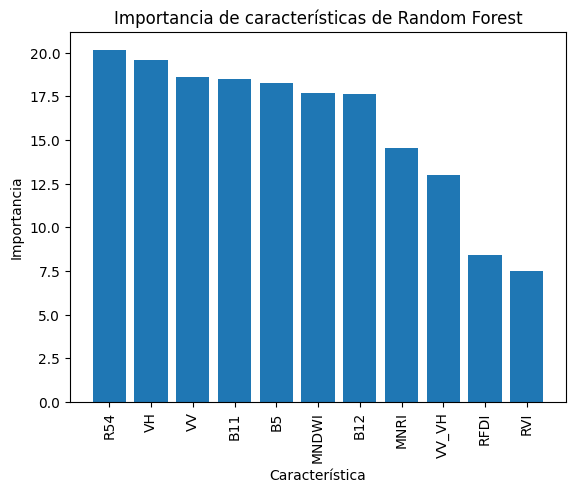

In [ ]:
# Gráfico de la importancia de cada variable
plt.bar(variable_importance.keys(), variable_importance.values())
plt.title('Importancia de características de Random Forest')
plt.xlabel('Característica')
plt.ylabel('Importancia')
plt.xticks(rotation=90, fontsize=10)
plt.show()

###Evaluación de los resultados

In [ ]:
#Extrae las caracteristicas de los puntos de validación 
validationRf = classifiedRf.sampleRegions(**{
                       'collection': validationPts,
                       'properties': ['Clase'],
                       'scale':10 ,     
                       'tileScale':2})
# Calcula la matriz
validationAccuracyRf = validationRf.errorMatrix('Clase', 'classification');
print('Matriz de confusión')
validationAccuracyRf   

Matriz de confusión


In [ ]:
# Calcula la precisión de la clasificación a partir de la Matriz de confusión 
print('##### VALIDATION ACCURACY #####');
print('RF: overall accuracy: ') 
(validationAccuracyRf.accuracy())


##### VALIDATION ACCURACY #####
RF: overall accuracy: 


In [ ]:
##Precisión del productos
PA = validationAccuracyRf.producersAccuracy();
#// Precisión del consumidor
print('Producers Accuracy ')
PA

Producers Accuracy 


In [ ]:
CA = validationAccuracyRf.consumersAccuracy();
print('Consumers Accuracy ') 
CA

Consumers Accuracy 


##Filtro de suavizado y outlier
El filtro de suavidado fue proporcionado por Andréa Nicolau (SIG/SERVIR-Amazonia) y adaptado por Lorena Caiza 

In [ ]:
mode = classifiedRf.focal_mode().reproject('EPSG:4326', scale=10);
# Suavizado ponderado utilizando una ventana 3x3
# Ponderación euclidiana de la distancia desde las esquinas
weights = [[1,2,1],
          [2,3,2],
          [1,2,1]];
# Kernel 3x3 con pesos de arriba
kernel = ee.Kernel.fixed(3,3,weights);

# Aplica filtro de paso alto en el vecindario con el kernel ponderado y fuerza operaciones en escala nativa de 10 metros
reducer = ee.Reducer.mode()
filtrado = classifiedRf.reduceNeighborhood(
    reducer=reducer,
    kernel=kernel)
##FILTRO DE OUTLIER
##Crea una imagen que muestra el número de píxeles conectados 
pixelcount = filtrado.focal_mode().connectedPixelCount(100,False);
##Filtra los píxeles que están conectados en grupos mayores de 4
countmask = pixelcount.select('classification_mode').gt(4)
## Retorna 1 si el valor a evaluar es mayor que el evaluado 
classMask = filtrado.focal_mode().eq(1)
classed = filtrado.updateMask(countmask).updateMask(classMask)##.updateMask(NDVIMask).updateMask(DTMMask).updateMask(Mask_VH)
#print(classed,'Classed')
#Crea el mapa 
Map = geemap.Map(center=(-2.6, -80.0), zoom=10)
Map.addLayer(classifiedRf.randomVisualizer(),{},'Clasificacion')
Map.addLayer(filtrado,{'min':1,'max':2,'palette':['green','blue']},'Clasificacion filtrada');
Map.addLayerControl()
Map

Map(center=[-2.6, -80.0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children…

In [ ]:
filtrado

In [ ]:
Map.draw_features
Map.addLayerControl()
roi = ee.FeatureCollection(Map.draw_features)
#Calcula la superfice en hectáreas 
getarea = filtrado.select('classification_mode').multiply(ee.Image.pixelArea()).divide(10000).reduceRegion(**{
          'reducer':ee.Reducer.sum(),
          'geometry':roi,
          'scale': 100,
          'maxPixels':1e13,
          'tileScale': 16}).get('classification_mode');
getarea.getInfo()

0

##Exporta los resultados 

In [ ]:
export=ee.batch.Export.image.toDrive(**{
  'image':filtrado,
  'description':'MANGLAR_2022',
  'folder':'MANGLAR',
  'scale' : 20,
  'maxPixels': 1e13
  })
export.start()